# Notes

Similar feature sets as iteration 1, except that we remove records that are considered as outliers at least in one column.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

sns.set_context('talk')

RND = 121

In [2]:
FILE_NAME = "df_train.csv"

input_train_path = os.path.join(
    '..',
    '..',
    'dataset',
    'feature-engineering',
    FILE_NAME.replace("train.csv","train-smote-65.csv")
)

df_train = pd.read_csv(input_train_path)
df_train.head()

input_test_path = os.path.join(
    '..',
    '..',
    'dataset',
    'feature-engineering',
    FILE_NAME.replace('train','test')
)
df_test = pd.read_csv(input_test_path)
df_test.head()

,startHour,startWeekday,duration,cCount,cMinPrice,cMaxPrice,cSumPrice,bCount,bMinPrice,bMaxPrice,...,availability_mainly_not_orderable,availability_mainly_orderable,address_-99,address_1,address_2,time_of_day_afternoon,time_of_day_early_morning,time_of_day_evening,onlineStatus_-99,onlineStatus_0
0,6.0,6.0,148.694,14.0,11.99,26.99,261.88,3.0,11.99,26.99,...,0,0,1,0,0,0,0,0,1,0
1,21.0,5.0,502.445,15.0,29.99,49.99,629.85,4.0,29.99,49.99,...,0,0,0,0,1,0,0,1,0,0
2,21.0,6.0,2268.294,33.0,4.99,19.99,373.76,5.0,5.00,17.99,...,0,0,0,0,1,0,0,1,0,0
3,9.0,6.0,98.096,5.0,19.99,34.99,129.95,5.0,19.99,34.99,...,0,0,0,0,1,0,0,0,0,0
4,8.0,7.0,548.471,6.0,9.99,39.99,119.95,4.0,9.99,39.99,...,0,0,0,1,0,0,0,0,1,0


# Prepare training and test set

In [3]:
row_count = df_train.shape[0]
row_count

238878

In [4]:
df_train.iloc[0]

startHour                                     16.000
startWeekday                                   5.000
duration                                      84.495
cCount                                         7.000
cMinPrice                                      3.990
cMaxPrice                                     29.990
cSumPrice                                    183.930
bCount                                         1.000
bMinPrice                                     29.990
bMaxPrice                                     29.990
bSumPrice                                     29.990
bStep                                        -99.000
maxVal                                      2500.000
customerScore                                582.000
accountLifetime                              359.000
payments                                      13.000
age                                           72.000
lastOrder                                    146.000
availability_-99                              

In [5]:
categorical_feature_list_initial = [
    'availability_-99', 'availability_completely_not_determinable',
    'availability_completely_not_orderable','availability_completely_orderable',
    'availability_mainly_not_determinable','availability_mainly_not_orderable', 
    'availability_mainly_orderable',
    'address_-99', 'address_1', 'address_2', 
    'time_of_day_afternoon','time_of_day_early_morning', 'time_of_day_evening', 
    'onlineStatus_-99','onlineStatus_0'
]

categorical_feature_list = []
for col in categorical_feature_list_initial:
    try:
        df_train[col] = df_train[col].astype(int)
        df_test[col] = df_test[col].astype(int)
        categorical_feature_list.append(col)
    except:
        print(f"{col} doesn't exist!")
        continue

In [6]:
target_class = 'order'

y_train = df_train[target_class].copy()
X_train = df_train.drop(labels=[target_class], axis=1)

y_test = df_test[target_class].copy()
X_test = df_test.drop(labels=[target_class], axis=1)

In [7]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(238878, 33) (238878,)
(128704, 33) (128704,)


In [8]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_auc_score

def evaluate_performance(y_true, y_pred, print_results = True):
    accuracy = accuracy_score(y_true, y_pred)
    f_score = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    
    if print_results:
        print(f"Accuracy : {accuracy:.3%}")
        print(f"F1-score : {f_score:.3%}")
        print(f"AUC: {auc:.3f}")
        print(classification_report(y_true, y_pred))
        
    return accuracy, f_score, auc

In [9]:
from sklearn.model_selection import KFold

def kfold_cv(clf, X_train, y_train, k = 10):
    kfold = KFold(random_state = RND, shuffle = True, n_splits = k)
    
    cv_accuracy = np.zeros(shape=k)
    cv_f1 = np.zeros(shape=k)
    cv_auc = np.zeros(shape=k)
    
    i = 0
    for train_index, val_index in kfold.split(X_train):
        X_tr = X_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        X_val = X_train.loc[val_index]
        y_val = y_train.loc[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        accuracy, f_score, auc = evaluate_performance(y_val, y_pred, print_results = False)
        print(f"Iteration {i+1}: Accuracy={accuracy:.3%} | F1-score={f_score:.3%} | AUC={auc:.3f}")
        
        cv_accuracy[i] = accuracy
        cv_f1[i] = f_score
        cv_auc[i] = auc
        
        i += 1
    
    print("Cross-validation results")
    print("========================")
    print(f"Accuracy: {np.mean(cv_accuracy):.3%} +- {np.std(cv_accuracy):.3%}")
    print(f"F1-score: {np.mean(cv_f1):.3%} +- {np.std(cv_f1):.3%}")
    print(f"AUC: {np.mean(cv_auc):.3f} +- {np.std(cv_auc):.3f}")

# Model Training and Evaluation

## Baseline: Logistic Regression without fine-tuning

In [10]:
from sklearn.linear_model import LogisticRegression

model_logres = LogisticRegression(random_state=RND, max_iter=200, solver='saga', penalty='elasticnet', l1_ratio=0.2)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_logres, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_logres.fit(X_train, y_train)

/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 1: Accuracy=67.672% | F1-score=68.903% | AUC=0.677


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 2: Accuracy=67.909% | F1-score=69.316% | AUC=0.679


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 3: Accuracy=67.603% | F1-score=69.001% | AUC=0.676


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 4: Accuracy=67.510% | F1-score=68.986% | AUC=0.675


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Iteration 5: Accuracy=67.759% | F1-score=68.952% | AUC=0.678
Cross-validation results
Accuracy: 67.691% +- 0.136%
F1-score: 69.032% +- 0.146%
AUC: 0.677 +- 0.001


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(l1_ratio=0.2, max_iter=200, penalty='elasticnet',
                   random_state=121, solver='saga')

In [11]:
y_pred = model_logres.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 68.324%
F1-score : 75.565%
AUC: 0.660
              precision    recall  f1-score   support

           0       0.51      0.59      0.55     41947
           1       0.79      0.73      0.76     86757

    accuracy                           0.68    128704
   macro avg       0.65      0.66      0.65    128704
weighted avg       0.70      0.68      0.69    128704



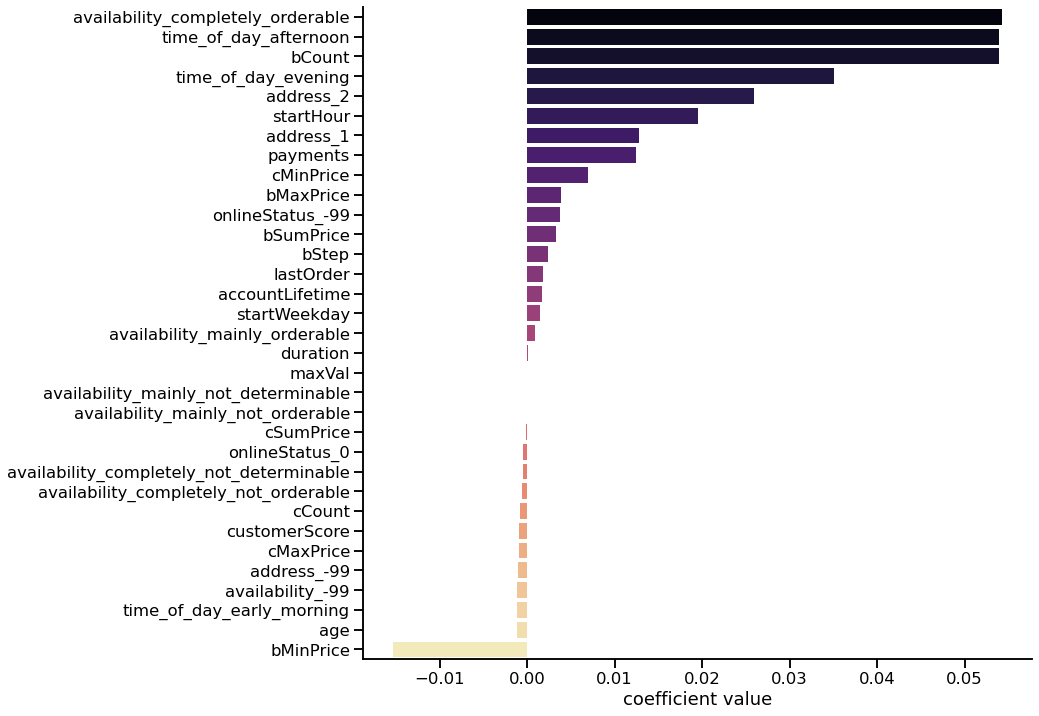

In [12]:
logres_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_logres.coef_[0]
    }
).sort_values(by='coef', ascending=False)
logres_coef['coef_abs'] = np.abs(logres_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=logres_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=RND)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_rf, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_rf.fit(X_train, y_train)

Iteration 1: Accuracy=91.906% | F1-score=91.981% | AUC=0.919
Iteration 2: Accuracy=91.958% | F1-score=92.136% | AUC=0.920
Iteration 3: Accuracy=91.678% | F1-score=91.851% | AUC=0.917
Iteration 4: Accuracy=91.841% | F1-score=91.996% | AUC=0.918
Iteration 5: Accuracy=91.927% | F1-score=92.033% | AUC=0.919
Cross-validation results
Accuracy: 91.862% +- 0.100%
F1-score: 92.000% +- 0.092%
AUC: 0.919 +- 0.001


RandomForestClassifier(random_state=121)

In [14]:
y_pred = model_rf.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 82.396%
F1-score : 87.463%
AUC: 0.777
              precision    recall  f1-score   support

           0       0.78      0.64      0.70     41947
           1       0.84      0.91      0.87     86757

    accuracy                           0.82    128704
   macro avg       0.81      0.78      0.79    128704
weighted avg       0.82      0.82      0.82    128704



In [15]:
model_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 121,
 'verbose': 0,
 'warm_start': False}

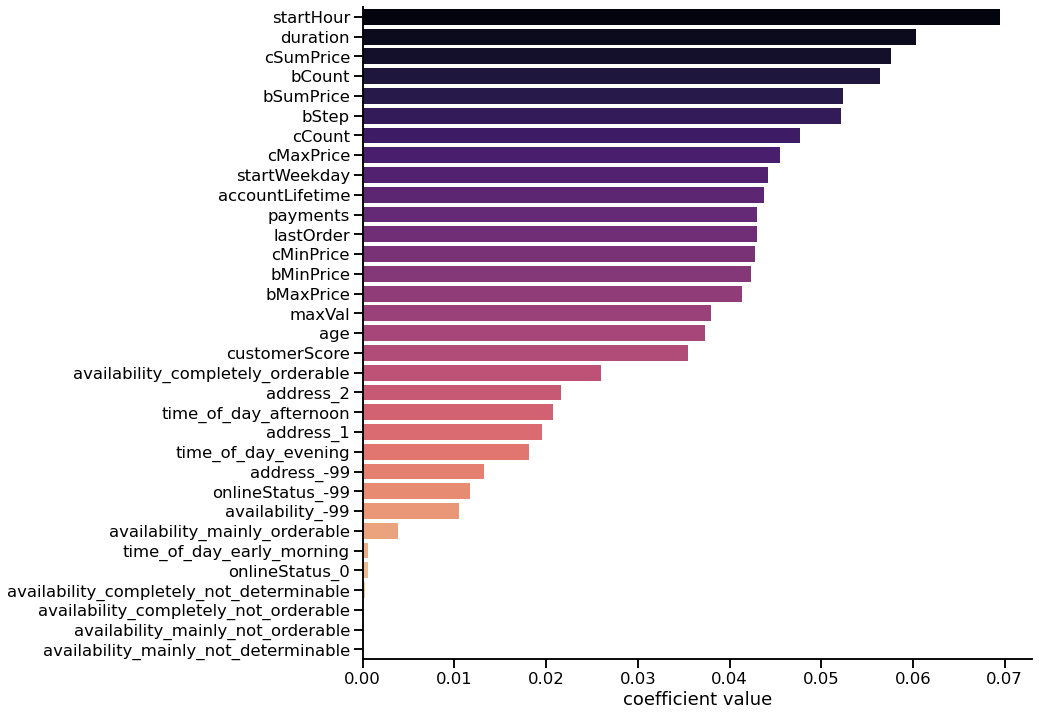

In [16]:
rf_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_rf.feature_importances_
    }
).sort_values(by='coef', ascending=False)
rf_coef['coef_abs'] = np.abs(rf_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=rf_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# LightGBM

In [17]:
categorical_feature_list

['availability_-99',
 'availability_completely_not_determinable',
 'availability_completely_not_orderable',
 'availability_completely_orderable',
 'availability_mainly_not_determinable',
 'availability_mainly_not_orderable',
 'availability_mainly_orderable',
 'address_-99',
 'address_1',
 'address_2',
 'time_of_day_afternoon',
 'time_of_day_early_morning',
 'time_of_day_evening',
 'onlineStatus_-99',
 'onlineStatus_0']

In [18]:
import lightgbm as lgbm

model_lgbm = lgbm.LGBMClassifier(
    random_state=RND,
    objective='binary',
    learning_rate=0.2,
    subsample=0.7,
    subsample_freq=3,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_lgbm, X_train, y_train, k=KFOLD_ITER)

## Train with the whole training set
model_lgbm.fit(X_train, y_train, categorical_feature=categorical_feature_list)

Iteration 1: Accuracy=84.835% | F1-score=85.461% | AUC=0.849
Iteration 2: Accuracy=84.789% | F1-score=85.578% | AUC=0.848
Iteration 3: Accuracy=84.800% | F1-score=85.534% | AUC=0.848
Iteration 4: Accuracy=84.622% | F1-score=85.367% | AUC=0.846
Iteration 5: Accuracy=85.097% | F1-score=85.759% | AUC=0.851
Cross-validation results
Accuracy: 84.829% +- 0.153%
F1-score: 85.540% +- 0.131%
AUC: 0.848 +- 0.002


/home/elvyna/miniconda3/envs/py37/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, objective='binary',
               random_state=121, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7,
               subsample_freq=3)

In [19]:
model_lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.2,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 121,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'silent': True,
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 3}

In [20]:
y_pred = model_lgbm.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 76.318%
F1-score : 83.252%
AUC: 0.704
              precision    recall  f1-score   support

           0       0.67      0.54      0.60     41947
           1       0.80      0.87      0.83     86757

    accuracy                           0.76    128704
   macro avg       0.73      0.70      0.71    128704
weighted avg       0.75      0.76      0.76    128704



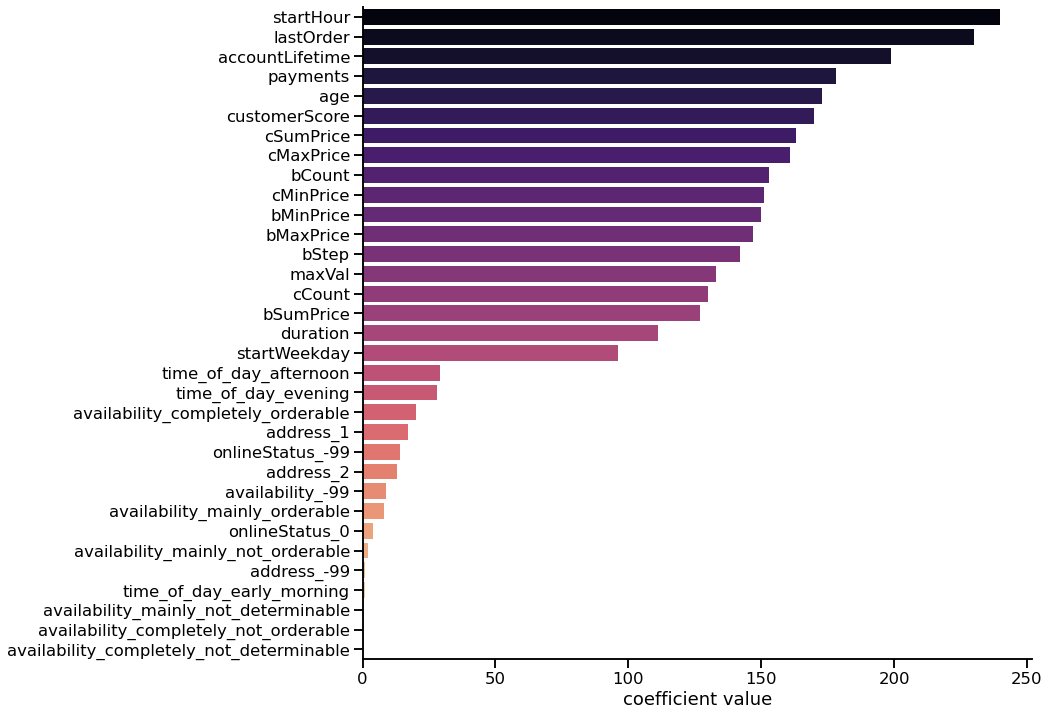

In [21]:
lgbm_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_lgbm.feature_importances_
    }
).sort_values(by='coef', ascending=False)
lgbm_coef['coef_abs'] = np.abs(lgbm_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=lgbm_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();

# Catboost

In [22]:
from catboost import CatBoostClassifier

## https://catboost.ai/en/docs/concepts/parameter-tuning
model_catboost = CatBoostClassifier(
    iterations=100,
    learning_rate=0.2,
    max_depth=10,
    l2_leaf_reg=0.1,
    random_state=RND
)

## Perform k-fold cross-validation
KFOLD_ITER = 5
kfold_cv(model_catboost, X_train, y_train, k=KFOLD_ITER)

## Fit model
model_catboost.fit(X_train, y_train, cat_features=categorical_feature_list)
# # Get predicted classes
# preds_class = model_catboost.predict(eval_data)
# # Get predicted probabilities for each class
# preds_proba = model_catboost.predict_proba(eval_data)
# # Get predicted RawFormulaVal
# preds_raw = model_catboost.predict(eval_data, prediction_type='RawFormulaVal')

0:	learn: 0.5880047	total: 379ms	remaining: 37.5s
1:	learn: 0.4973946	total: 512ms	remaining: 25.1s
2:	learn: 0.4591397	total: 647ms	remaining: 20.9s
3:	learn: 0.4299104	total: 782ms	remaining: 18.8s
4:	learn: 0.4179632	total: 1.02s	remaining: 19.3s
5:	learn: 0.4082537	total: 1.32s	remaining: 20.7s
6:	learn: 0.4018460	total: 1.58s	remaining: 21s
7:	learn: 0.3962599	total: 1.8s	remaining: 20.8s
8:	learn: 0.3925142	total: 2.08s	remaining: 21s
9:	learn: 0.3879468	total: 2.37s	remaining: 21.3s
10:	learn: 0.3847355	total: 2.58s	remaining: 20.9s
11:	learn: 0.3769484	total: 2.77s	remaining: 20.3s
12:	learn: 0.3749386	total: 2.94s	remaining: 19.7s
13:	learn: 0.3700292	total: 3.08s	remaining: 18.9s
14:	learn: 0.3671841	total: 3.24s	remaining: 18.4s
15:	learn: 0.3656021	total: 3.39s	remaining: 17.8s
16:	learn: 0.3636455	total: 3.54s	remaining: 17.3s
17:	learn: 0.3617666	total: 3.68s	remaining: 16.8s
18:	learn: 0.3590183	total: 3.91s	remaining: 16.7s
19:	learn: 0.3556363	total: 4.1s	remaining: 16

In [23]:
model_catboost.get_params()

{'iterations': 100,
 'learning_rate': 0.2,
 'l2_leaf_reg': 0.1,
 'max_depth': 10,
 'random_state': 121}

In [24]:
y_pred = model_catboost.predict(X_test)
accuracy, f_score, auc = evaluate_performance(y_test, y_pred)

Accuracy : 78.146%
F1-score : 84.620%
AUC: 0.722
              precision    recall  f1-score   support

           0       0.71      0.55      0.62     41947
           1       0.80      0.89      0.85     86757

    accuracy                           0.78    128704
   macro avg       0.76      0.72      0.73    128704
weighted avg       0.77      0.78      0.77    128704



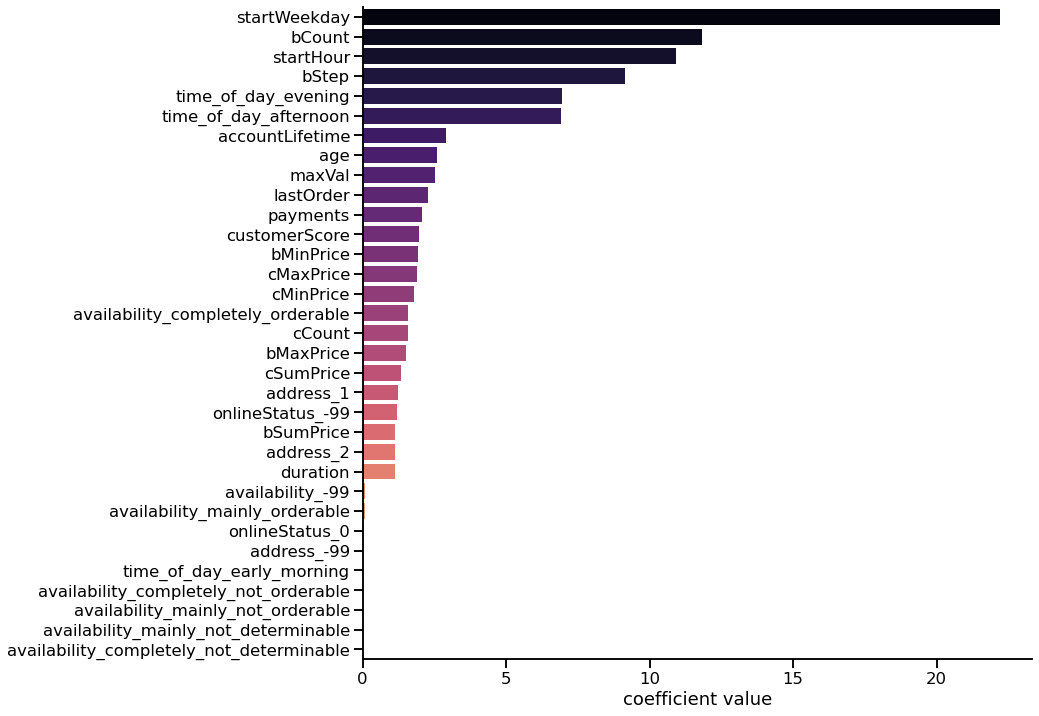

In [25]:
catboost_coef = pd.DataFrame(
    data = {
        'feature_name': X_train.columns,
        'coef': model_catboost.feature_importances_
    }
).sort_values(by='coef', ascending=False)
catboost_coef['coef_abs'] = np.abs(catboost_coef['coef'])


f, ax = plt.subplots(figsize=(12, 12))
sns.barplot(
    data=catboost_coef,
    y='feature_name',
    x='coef',
    orient='h',
    palette='magma',
    ax=ax
);

plt.xlabel('coefficient value')
plt.ylabel('')
sns.despine();